In [1]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
movies = pd.read_csv(
    "https://data-bootcamp-ztc.s3.amazonaws.com/movies_complete_cleaned.csv"
)

awards = pd.read_csv(
    "https://data-bootcamp-ztc.s3.amazonaws.com/parsed_awards_table.csv"
)

movies_sel = movies[["name", "plot"]]

awards_sel = awards[["name", "oscar wins and nominations"]]

df = pd.merge(movies_sel, awards_sel, how="right", on="name")

df["oscar_nom"] = [1 if x != 0 else 0 for x in df["oscar wins and nominations"]]

df = df[["name", "plot", "oscar_nom"]]

df["plot"].fillna("", inplace=True)

df.head()

,name,plot,oscar_nom
0,Doctor Strange,"Marvel's ""Doctor Strange"" follows the story of...",1
1,Sleight,A young street magician (Jacob Latimore) is le...,0
2,Silence,The story of two Catholic missionaries (Andrew...,1
3,Manchester by the Sea,"Lee Chandler is a brooding, irritable loner wh...",1
4,Dirty Grandpa,"Jason Kelly, the grandson of Dick Kelly, loses...",0


<IPython.core.display.Javascript object>

First we're going to clean the text data.

Remove URLs and HTML

Remove punctuation

In [3]:
import string


def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)


df["plot"] = [remove_punct(x) for x in df["plot"]]

<IPython.core.display.Javascript object>

Remove stopwords

In [4]:
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))


def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)


df["plot"] = [remove_stopwords(x) for x in df["plot"]]

<IPython.core.display.Javascript object>

Stemming. Bundling together words of same root.


In [5]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()


def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]

    return " ".join(text)

<IPython.core.display.Javascript object>

In [6]:
df["plot"] = [stemming(x) for x in df["plot"]]

<IPython.core.display.Javascript object>

#### Tokenization

In [7]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

df["tokens"] = df["plot"].map(tokenizer.tokenize)

<IPython.core.display.Javascript object>

In [8]:
df[["plot", "tokens"]].head(10)

,plot,tokens
0,marvel doctor strang follow stori talent neuro...,"[marvel, doctor, strang, follow, stori, talent..."
1,young street magician jacob latimor left care ...,"[young, street, magician, jacob, latimor, left..."
2,stori two cathol missionari andrew garfield ad...,"[stori, two, cathol, missionari, andrew, garfi..."
3,lee chandler brood irrit loner work handyman b...,"[lee, chandler, brood, irrit, loner, work, han..."
4,jason kelli grandson dick kelli lose grandmoth...,"[jason, kelli, grandson, dick, kelli, lose, gr..."
5,,[]
6,movi portrait one import tragic moment america...,"[movi, portrait, one, import, tragic, moment, ..."
7,nation manhunt order rebelli kid foster uncl g...,"[nation, manhunt, order, rebelli, kid, foster,..."
8,rural england 1865 katherin stifl loveless mar...,"[rural, england, 1865, katherin, stifl, lovele..."
9,rocki young woman want start better life siste...,"[rocki, young, woman, want, start, better, lif..."


<IPython.core.display.Javascript object>

### Bag of words

#### Counts

A bag of words just associates an index to each word in the vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer


def count_vect(data, ngrams=(1, 1)):
    count_vectorizer = CountVectorizer(ngram_range=ngrams)
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

<IPython.core.display.Javascript object>

In [10]:
train_counts, count_vectorizer = count_vect(df["plot"])
# test_counts = count_vectorizer.transform(test["text"])

<IPython.core.display.Javascript object>

Test to see if CountVectorizer worked as expected

In [11]:
# train.shape

<IPython.core.display.Javascript object>

In [12]:
# train_counts.todense().shape

<IPython.core.display.Javascript object>

In [13]:
# len(train_counts.todense()[0].tolist()[0])

<IPython.core.display.Javascript object>

In [14]:
# train.text.iloc[0]

<IPython.core.display.Javascript object>

In [15]:
# print(train_counts.todense()[0][0:].sum())

<IPython.core.display.Javascript object>

In [16]:
train_counts, count_vectorizer = count_vect(df["plot"], ngrams=(1, 2))
# test_counts = count_vectorizer.transform(test["text"])

# print(train_counts.todense()[0][0:].sum())

<IPython.core.display.Javascript object>

#### TF IDF

Downweighting frequently occuring words in the feature vectors. Frequently occuring words typically don't contain useful information therefore TF - IDF is great for assessing word relevancy.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


train_tfidf, tfidf_vectorizer = tfidf(df["plot"])
# test_tfidf = tfidf_vectorizer.transform(test["text"])

<IPython.core.display.Javascript object>

Test to see if TfidfVectorizer worked as expected

In [18]:
[x for x in train_tfidf.todense()[0][0:].tolist()[0] if x != 0]

[0.11952068434225185,
 0.10205648418868611,
 0.10111996597487312,
 0.13408129532073912,
 0.1778557604794263,
 0.16061137170374395,
 0.14646895794057832,
 0.0936489974694706,
 0.1180522774271012,
 0.09392999981033405,
 0.1778557604794263,
 0.08296609555462807,
 0.165000250116696,
 0.32029999183064123,
 0.14545151644559592,
 0.08223605698639767,
 0.1827361438014501,
 0.1174914505962811,
 0.18902805221722108,
 0.07744422053836449,
 0.11392315323130499,
 0.3351525770866041,
 0.19789599905959815,
 0.14313314021045445,
 0.14984039485854794,
 0.18902805221722108,
 0.05926430371303637,
 0.09772982786038015,
 0.09013179719583564,
 0.09450307315471759,
 0.08308060392091934,
 0.14545151644559592,
 0.07250181678344486,
 0.3228937344466019,
 0.11005349322021403,
 0.12175762996090522,
 0.11147815802478095,
 0.19789599905959815,
 0.1553369047829554,
 0.111689474142118,
 0.1353846566612666,
 0.08493671710631567]

<IPython.core.display.Javascript object>

In [19]:
print(train_tfidf.todense()[0][0:].sum())

5.910918356366323


<IPython.core.display.Javascript object>

In [54]:
# train_tfidf, tfidf_vectorizer = tfidf(df["plot"], ngrams=(1, 1))
# # test_tfidf = tfidf_vectorizer.transform(test["text"])

# print(train_tfidf.todense()[0][0:].sum())

5.910918356366323


<IPython.core.display.Javascript object>

#### Visualizing the embeddings


In [55]:
X_counts = train_counts
X_tfidf = train_tfidf
y = df["oscar_nom"].values

<IPython.core.display.Javascript object>

Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). 

Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.

In [56]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ["orange", "blue", "blue"]
    if plot:
        plt.scatter(
            lsa_scores[:, 0],
            lsa_scores[:, 1],
            s=8,
            alpha=0.8,
            c=test_labels,
            cmap=matplotlib.colors.ListedColormap(colors),
        )
        red_patch = mpatches.Patch(color="orange", label="no oscar nomination")
        green_patch = mpatches.Patch(color="blue", label="oscar nomination")
        plt.legend(handles=[red_patch, green_patch], prop={"size": 16})


<IPython.core.display.Javascript object>

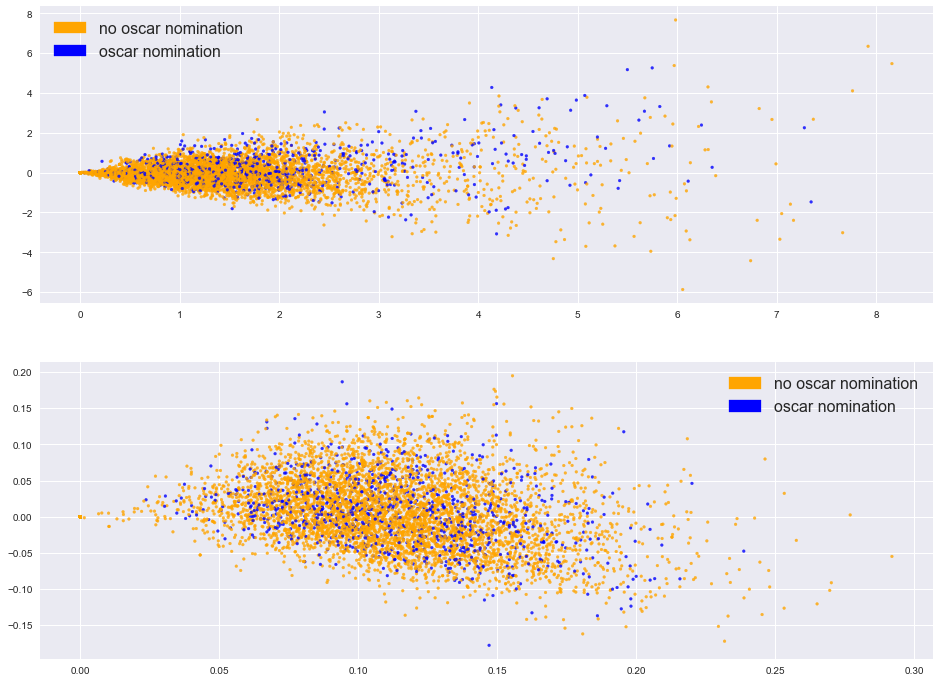

<IPython.core.display.Javascript object>

In [57]:
plt.figure(1, figsize=(16, 12))
plt.subplot(2, 1, 1)
plot_LSA(X_counts, y)
plt.subplot(2, 1, 2)
plot_LSA(X_tfidf, y)

TF IDF in this situation has better linearly separable classes.

### Basic Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

<IPython.core.display.Javascript object>

#### With CountVectorizer

In [59]:
X = train_counts
y = df["oscar_nom"].values

X_train_counts, X_test, y_train_counts, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)

<IPython.core.display.Javascript object>

In [60]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_counts, y_train_counts)

LogisticRegression(class_weight='balanced')

<IPython.core.display.Javascript object>

In [61]:
y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred)
print(f"Counts Model Score: {f1score * 100} %")

Counts Model Score: 12.927756653992395 %


<IPython.core.display.Javascript object>

#### With TfidfVectorizer

In [62]:
# df_test.head(2)

NameError: name 'df_test' is not defined

<IPython.core.display.Javascript object>

In [69]:
# X = df_test["itidf"].values.reshape(-1, 1)
X = train_tfidf
y = df["oscar_nom"].values

<IPython.core.display.Javascript object>

In [70]:
# df_test["itidf"][0]

<IPython.core.display.Javascript object>

In [71]:
X_train_tfidf, X_test, y_train_tfidf, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)

<IPython.core.display.Javascript object>

In [72]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_tfidf, y_train_tfidf)

LogisticRegression(class_weight='balanced')

<IPython.core.display.Javascript object>

In [73]:
y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred)
print(f"Tfidf Model Score: {f1score * 100} %")

Tfidf Model Score: 27.24935732647815 %


<IPython.core.display.Javascript object>

In [79]:
import os

# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.2'
spark_version = "spark-3.0.2"
os.environ["SPARK_VERSION"] = spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# # Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark

findspark.init()

/bin/bash: apt-get: command not found
/bin/bash: apt-get: command not found
/bin/bash: wget: command not found
tar: Error opening archive: Failed to open 'spark-3.0.2-bin-hadoop2.7.tgz'


Exception: Unable to find py4j, your SPARK_HOME may not be configured correctly

<IPython.core.display.Javascript object>

In [76]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Hashing").getOrCreate()

Exception: Java gateway process exited before sending its port number

<IPython.core.display.Javascript object>